In [1]:
import os
from collections import defaultdict
import numpy as np
import pickle
import matplotlib.pyplot as plt
import texttable as tt
%matplotlib inline

sym_nr_rates = ['0.0', '0.2', '0.4', '0.6', '0.8']
asym_nr_rates = ['0.1','0.2','0.3','0.4']

def load_train_history(target_dir_list):
    history = defaultdict(lambda: defaultdict(list))
    for target_dir in target_dir_list:
        for file in sorted(os.listdir(target_dir)):
            file_path = os.path.join(target_dir, file)
            file = os.path.splitext(file)[0]
            file = file.replace('nr', '', 1) 
            file = file.split('_')
            if 'scale' in file:
                nr, loss_name, scale, scale_rate = file[0], file[1], file[2], file[3]
                loss_name = loss_name.replace('and', '+')
                loss_name = loss_name.upper() 
                loss_name = str(int(float(scale_rate))) + loss_name
            elif 'ab' in file:
                nr, loss_name, ab, alpha, beta = file[0], file[1], file[2], file[3], file[4]
                loss_name = loss_name.replace('and', '+')
                loss_name = loss_name.upper() 
                loss_name = loss_name + ' alpha=' + str((float(alpha))) + ' beta=' + str((float(beta)))
            else:
                nr, loss_name = file[0], file[1]
                loss_name = loss_name.replace('and', '+')
                loss_name = loss_name.upper()
            loss_name = loss_name.replace("FOCALLOSS", "FL")
#             if loss_name == 'NLNL':
#                 continue
            with open(file_path, 'rb') as handle:
                train_history = pickle.load(handle)
            history[loss_name][nr].append(train_history)

    # Compute Avg and std
    for loss_name in history:
        for nr in history[loss_name]:
            test_acc_arr = []
            for arr in history[loss_name][nr]:
                test_acc_arr.append(arr['test_acc'])
            
            prev = None
            for i, item in enumerate(test_acc_arr):
                if prev is None:
                    prev = len(item)
                elif prev != len(item):
                    print(loss_name, nr, i)
                
            test_acc_arr = np.asarray(test_acc_arr)
            history[loss_name][nr].append(test_acc_arr.mean(axis=0))
            history[loss_name][nr].append(test_acc_arr.std(axis=0))    
    return history


def plot_table(history, key, nr_rates):
    tab = tt.Texttable()
    tab.set_cols_align(['l']+['c']*len(nr_rates))
    tab.set_cols_width([10]+[15]*len(nr_rates))

    header = ['Loss'] + nr_rates
    tab.header(header)
    
    for loss_name in history:
        row = [loss_name]
        for nr in nr_rates:
            if nr in history[loss_name]:
                mean = "{0:.2f}".format(history[loss_name][nr][-2][-1] * 100)
                std = "{0:.2f}".format(history[loss_name][nr][-1][-1] * 100)
                payload = mean + u"\u00B1" + std
                row.append(payload)
        while len(row) != len(nr_rates)+1:
            row.append("")
        tab.add_row(row)
    return tab.draw()


def plot_graph_by_loss(history, loss_name, key, nr_rates):
    fig = plt.figure(figsize=(10, 6), dpi= 150, facecolor='w', edgecolor='k')
    palette = plt.get_cmap('Set3')
    color_index = 0
    for nr in nr_rates:
        label = loss_name + '_' + nr
        plt.plot(history[loss_name][nr][-2],
                 color=palette(color_index),
                 linewidth=1.2,
                 alpha=0.9, 
                 label=label)
        color_index += 1
    plt.title(loss_name + ' ' + key)
    plt.ylabel(key)
    plt.xlabel('Epoch') 
    plt.legend(loc=0, ncol=1)
    plt.show()
    return


def plot_graph_by_nr(history, nr, key):
    fig = plt.figure(figsize=(10, 6), dpi= 150, facecolor='w', edgecolor='k')
    palette = plt.get_cmap('Set3')
    color_index = 0
    for loss_name in history:
        label = loss_name + '_' + nr
        plt.plot(history[loss_name][nr][-2],
                 color=palette(color_index),
                 linewidth=1.2,
                 alpha=0.9, 
                 label=label)
        color_index += 1
    plt.title(nr + ' ' + key)
    plt.ylabel(key)
    plt.xlabel('Epoch') 
    plt.legend(loc=0, ncol=1)
    plt.show()
    return


def table_to_latex(history, nr_rates):
    for loss_name in history:
        row = '& \t' + loss_name + '\t'
        for nr in nr_rates:
            if nr in history[loss_name]:
                mean = "{0:.2f}".format(history[loss_name][nr][-2][-1] * 100)
                std = "{0:.2f}".format(history[loss_name][nr][-1][-1] * 100)
                payload = ' & $ ' + mean + '\pm' + std + ' $ '
                row += payload
        print(row)
    return 


<h2>Plot CIFAR-10 Test Acc Table<h2>

In [2]:
'''
    Notes: CIFAR-10
    Epoch: 120 (1000 for NLNL)
    L2 = 1e-4
    Alpha/Beta Default = 1.0/1.0
    
    ===Sym===
    SCE:  Alpha=0.1  Beta=1.0
    GCE/NGCE: q=0.7
    
    ===Asym===
    SCE:  Alpha=0.1  Beta=5.0
    GCE/NGCE: q=0.7
    
'''

# Sym
print("CIFAR-10-Sym")
target_dir_list = ['checkpoints/cifar10/sym/run1',
                   'checkpoints/cifar10/sym/run2',
                   'checkpoints/cifar10/sym/run3']
cifar_10_history_sym = load_train_history(target_dir_list)
print((plot_table(cifar_10_history_sym, 'test_acc', sym_nr_rates)))

# Asym
print("CIFAR-10-Asym")
target_dir_list = ['checkpoints/cifar10/asym/run1',
                   'checkpoints/cifar10/asym/run2',
                   'checkpoints/cifar10/asym/run3']
cifar_10_history_asym = load_train_history(target_dir_list)
print((plot_table(cifar_10_history_asym, 'test_acc', asym_nr_rates)))


print('LATEX CIFAR-10 Sym')
table_to_latex(cifar_10_history_sym, sym_nr_rates)

print('LATEX CIFAR-10 Asym')
table_to_latex(cifar_10_history_asym, asym_nr_rates)

CIFAR-10-Sym
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    Loss    |       0.0       |       0.2       |       0.4       |       0.6       |       0.8       |
+============+=================+=================+=================+=================+=================+
| CE         |   90.36±0.03    |   75.90±0.28    |   60.28±0.27    |   40.90±0.35    |   19.65±0.46    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| DMI        |   90.51±0.28    |   76.26±0.36    |   61.54±0.42    |   42.37±0.80    |   20.68±0.37    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| FL         |   89.63±0.25    |   74.59±0.49    |   57.55±0.39    |   38.91±0.62    |   19.43±0.27    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| GCE        |   89.38±0.23    |   87.37±0

<h2>Plot CIFAR-100 Test Acc Table<h2>

In [3]:
'''
    Notes: CIFAR-100
    Epoch: 200 
    L2 = 1e-5
    Alpha/Beta Default = 1.0/1.0

    ===Sym===
    GCE: q=0.7
    NGCE: q=0.3
    ===Alpha/Beta===
    GCE+RCE:  Alpha=1.0  Beta=0.1 
    NCE+MAE:  Alpha=10.0 Beta=1.0
    NCE+RCE:  Alpha=10.0 Beta=0.1
    NGCE+MAE: Alpha=10.0 Beta=1.0 q=0.2
    NGCE+RCE: Alpha=10.0 Beta=0.1 q=0.2
    SCE    :  Alpha=6.0  Beta=0.1
    
    
    ===Asym===
    GCE: q=0.7
    NGCE: q=0.3
    ===Alpha/Beta===
    GCE+RCE:  Alpha=1.0  Beta=0.1 
    NCE+MAE:  Alpha=5.0 Beta=1.0
    NCE+RCE:  Alpha=5.0 Beta=0.1
    NGCE+MAE: Alpha=10.0 Beta=1.0 q=0.2
    NGCE+RCE: Alpha=10.0 Beta=0.1 q=0.2
    SCE    :  Alpha=2.0  Beta=0.1
'''

print('CIFAR-100-Sym')
target_dir_list = ['checkpoints/cifar100/sym/run1',
                   'checkpoints/cifar100/sym/run2',
                   'checkpoints/cifar100/sym/run3']
cifar_100_history_sym = load_train_history(target_dir_list)
print((plot_table(cifar_100_history_sym, 'test_acc', sym_nr_rates)))


print('CIFAR-100-Asym')
target_dir_list = ['checkpoints/cifar100/asym/run1',
                   'checkpoints/cifar100/asym/run2',
                   'checkpoints/cifar100/asym/run3']
cifar_100_history_asym = load_train_history(target_dir_list)
print((plot_table(cifar_100_history_asym, 'test_acc', ['0.1', '0.2', '0.3', '0.4'])))

print('LATEX CIFAR-100 Sym')
table_to_latex(cifar_100_history_sym, sym_nr_rates)

print('LATEX CIFAR-100 Asym')
table_to_latex(cifar_100_history_asym, asym_nr_rates)

CIFAR-100-Sym
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    Loss    |       0.0       |       0.2       |       0.4       |       0.6       |       0.8       |
+============+=================+=================+=================+=================+=================+
| CE         |   70.89±0.22    |   56.99±0.41    |   41.40±0.36    |   22.15±0.40    |    7.58±0.44    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| FL         |   70.61±0.44    |   56.10±0.48    |   40.77±0.62    |   22.14±1.00    |    7.21±0.25    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| GCE        |   69.00±0.56    |   65.28±0.56    |   58.94±0.50    |   45.18±0.93    |   16.18±0.46    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| GCE+MAE    |   60.52±1.00    |   60.63±

<h2>Plot MNIST Test Acc Table<h2>

In [4]:
print('MNIST-Sym')
target_dir_list = ['checkpoints/mnist/sym/run1',
                   'checkpoints/mnist/sym/run2',
                   'checkpoints/mnist/sym/run3']
mnist_history_sym = load_train_history(target_dir_list)
print((plot_table(mnist_history_sym, 'test_acc', sym_nr_rates)))


print('MNIST-Asym')
target_dir_list = ['checkpoints/mnist/asym/run1',
                   'checkpoints/mnist/asym/run2',
                   'checkpoints/mnist/asym/run3']
mnist_history_asym = load_train_history(target_dir_list)
print((plot_table(mnist_history_asym, 'test_acc', ['0.1', '0.2', '0.3', '0.4'])))


print('LATEX MNIST Sym')
table_to_latex(mnist_history_sym, sym_nr_rates)

print('LATEX MNIST Asym')
table_to_latex(mnist_history_asym, ['0.1', '0.2', '0.3', '0.4'])


MNIST-Sym
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    Loss    |       0.0       |       0.2       |       0.4       |       0.6       |       0.8       |
+============+=================+=================+=================+=================+=================+
| CE         |   99.25±0.08    |   97.42±0.06    |   94.21±0.54    |   86.00±1.48    |   47.08±1.15    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| FL         |   99.30±0.02    |   97.45±0.19    |   94.71±0.25    |   85.76±1.85    |   49.77±2.26    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| GCE        |   99.27±0.01    |   99.20±0.06    |   98.82±0.05    |   97.43±0.23    |   12.77±2.00    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| GCE+MAE    |   99.29±0.05    |   99.18±0.03

<h2>Plot CIFAR Graph<h2>
<p style="font-size: 14px;"> Plot test acc by loss function as key</p >

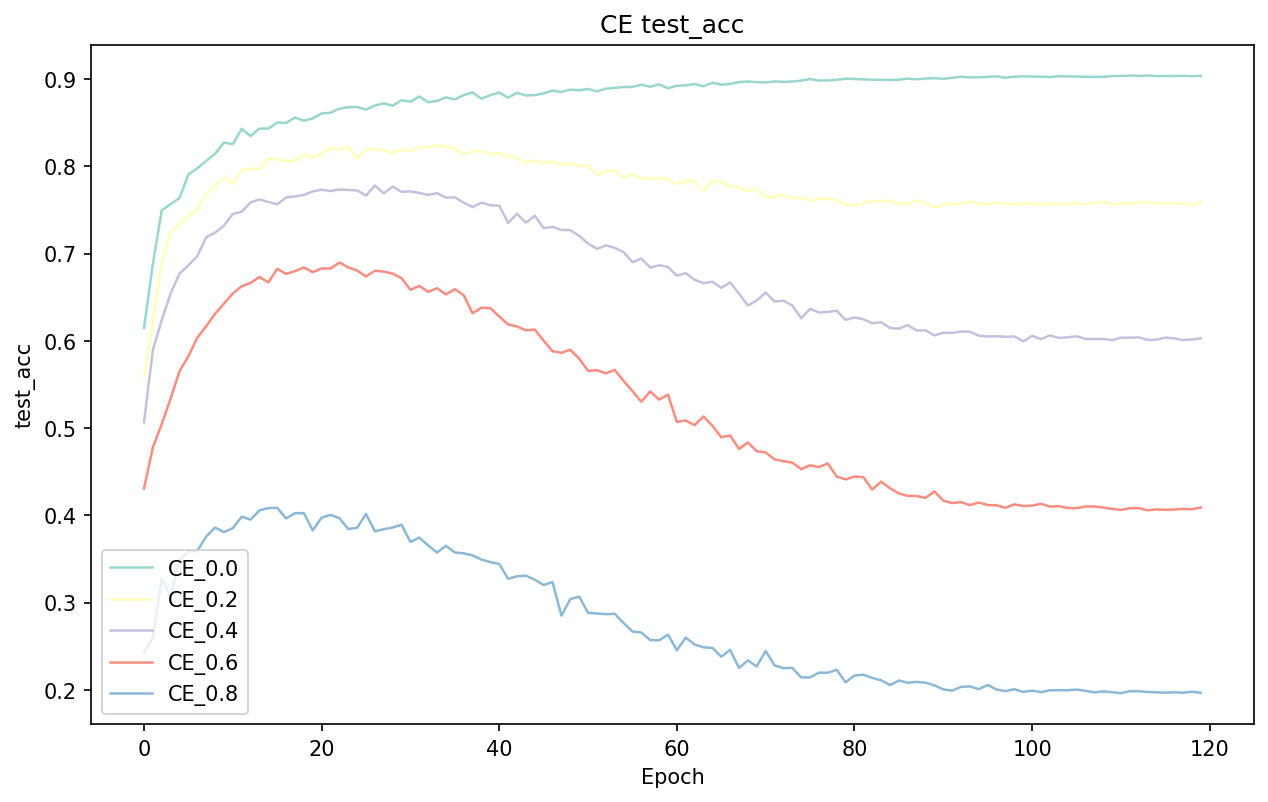

In [5]:
plot_graph_by_loss(cifar_10_history_sym, 'CE', 'test_acc', sym_nr_rates)


<h2>Plot CIFAR Graph<h2>
<p style="font-size: 14px;"> Plot test acc by noise rate as key</p >

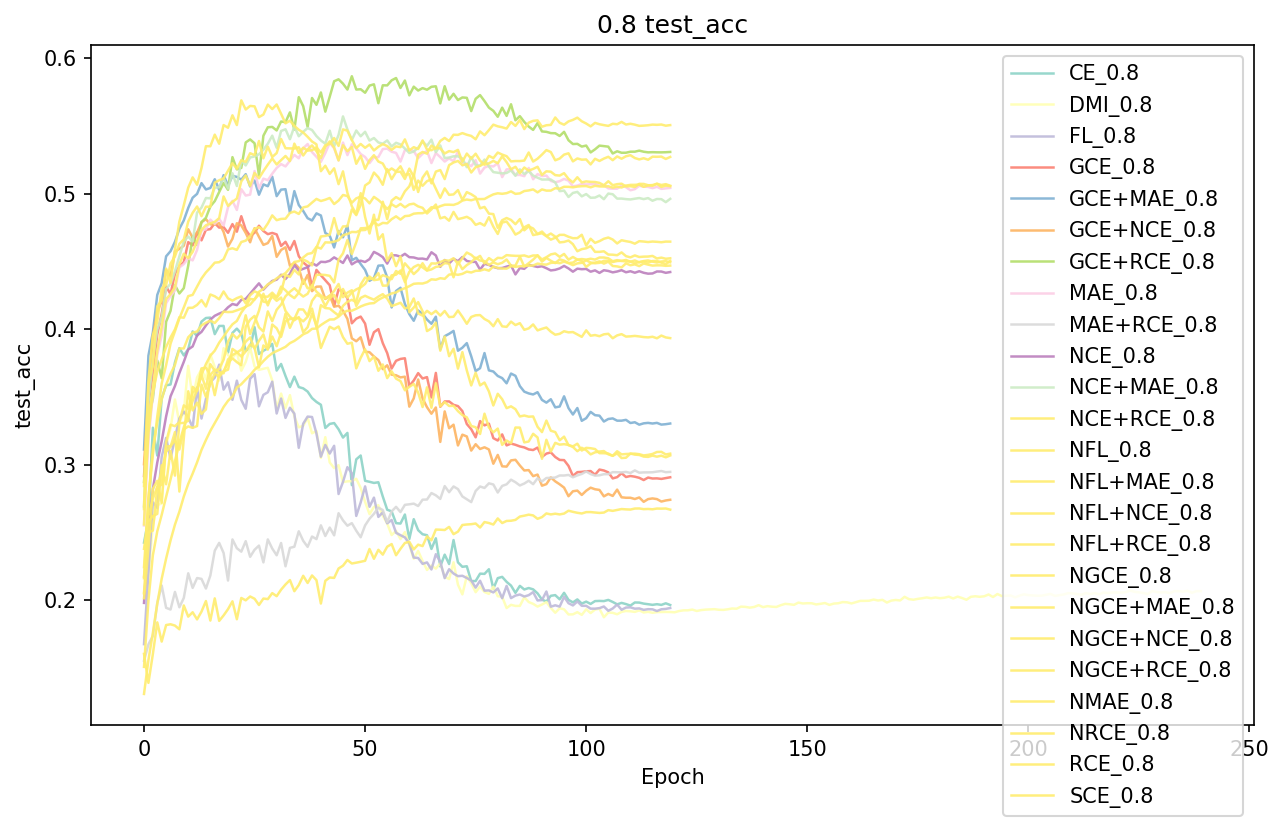

In [6]:
if 'NLNL' in cifar_10_history_sym:
    cifar_10_history_sym.pop('NLNL')

plot_graph_by_nr(cifar_10_history_sym, '0.8', 'test_acc')


<h2>Plot Clothing1M Test Acc Table <h2>



In [7]:
'''
    Notes: Clothing1M
    Epoch: 10 
    L2 = 1e-3
    LR = 1e-3 cosine decays to 0
    BatchSize: 128
    Alpha/Beta Default = 1.0/1.0
    Pretrained ResNet-50, modified last fc to nn.Linear(2048, 14)

    ===Alpha/Beta===
    GCE+RCE:  Alpha=1.0  Beta=0.1 
    NCE+RCE:  Alpha=10.0 Beta=0.1
    SCE    :  Alpha=0.1  Beta=1.0
    
'''


def load_train_history_clothing(target_dir):
    history = defaultdict(dict)
    loss_list = []
    for file in sorted(os.listdir(target_dir)):
        file_path = os.path.join(target_dir, file)
        file_name = os.path.splitext(file)[0]
        loss_name = file_name.replace('_clothing1m', '')
        loss_name = loss_name.replace('and', '+')
        loss_name = loss_name.upper()
        with open(file_path, 'rb') as handle:
            train_history = pickle.load(handle)
        history[loss_name] = train_history
        loss_list.append(loss_name)
    return history, loss_list

def plot_table_clothing(history, loss_list):
    tab = tt.Texttable()
    tab.set_cols_align(['l']+['c']*len(loss_list))
    tab.set_cols_width([10]+[15]*len(loss_list))

    header = ['ACC/Loss'] + loss_list
    tab.header(header)
    
    row = ['Test Accs']
    for loss_name in history:
        target = "{0:.2f}".format(history[loss_name]['test_acc'][-1] * 100)
        row.append(target)
    tab.add_row(row)
    return tab.draw()


target_dir = 'checkpoints/clothing1m/'
history, loss_list = load_train_history_clothing(target_dir)
print((plot_table_clothing(history, loss_list)))


+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|  ACC/Loss  |       CE        |       GCE       |     GCE_RCE     |     NCE_RCE     |     NFL_RCE     |       SCE       |
+============+=================+=================+=================+=================+=================+=================+
| Test Accs  |     67.590      |     68.630      |     57.710      |     67.790      |     67.740      |     66.700      |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+


<h1>Plot Figs for paper</h1>

In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_style("whitegrid")

loss_style = {
    'CE': {'color': 'b', 'linestyle': '-'},
    'GCE': {'color': 'r', 'linestyle': '-'},
    'RCE': {'color': 'c', 'linestyle': '-'},
    'FL': {'color': 'r', 'linestyle': '-'},
    '1RCE': {'color': 'm', 'linestyle': '--'},
    '2RCE': {'color': 'r', 'linestyle': '--'},
    '4RCE': {'color': 'y', 'linestyle': '--'},
    '5RCE': {'color': 'c', 'linestyle': '--'},
    '10RCE': {'color': 'salmon', 'linestyle': '--'},
    '20RCE': {'color': 'orange', 'linestyle': '--'},
    '40RCE': {'color': 'y', 'linestyle': '--'},
    '50RCE': {'color': 'c', 'linestyle': '--'},
    '100RCE': {'color': 'salmon', 'linestyle': '--'},
    'NRCE': {'color': 'c', 'linestyle': '--'},
    'GCE+MAE': {'color': 'palegreen', 'linestyle': '-'},
    'GCE+RCE': {'color': 'orange', 'linestyle': '-'},
    'MAE': {'color': 'm', 'linestyle': '-'},
    '1MAE': {'color': 'm', 'linestyle': '--'},
    '2MAE': {'color': 'r', 'linestyle': '--'},
    '4MAE': {'color': 'y', 'linestyle': '--'},
    '5MAE': {'color': 'c', 'linestyle': '--'},
    '10MAE': {'color': 'salmon', 'linestyle': '--'},
    '20MAE': {'color': 'orange', 'linestyle': '--'},
    '40MAE': {'color': 'y', 'linestyle': '--'},
    '50MAE': {'color': 'c', 'linestyle': '--'},
    '100MAE': {'color': 'salmon', 'linestyle': '--'},
    'NMAE': {'color': 'm', 'linestyle': '--'},
    'NCE': {'color': 'b', 'linestyle': '--'},
    '1NCE': {'color': 'm', 'linestyle': '--'},
    '2NCE': {'color': 'r', 'linestyle': '--'},
    '4NCE': {'color': 'y', 'linestyle': '--'},
    '5NCE': {'color': 'c', 'linestyle': '--'},
    '10NCE': {'color': 'salmon', 'linestyle': '--'},
    'NGCE': {'color': 'r', 'linestyle': '--'},
    '1NGCE': {'color': 'm', 'linestyle': '--'},
    '2NGCE': {'color': 'r', 'linestyle': '--'},
    '4NGCE': {'color': 'y', 'linestyle': '--'},
    '5NGCE': {'color': 'c', 'linestyle': '--'},
    '10NGCE': {'color': 'salmon', 'linestyle': '--'},
    'NFL': {'color': 'r', 'linestyle': '--'},
    '1NFL': {'color': 'm', 'linestyle': '--'},
    '2NFL': {'color': 'r', 'linestyle': '--'},
    '4NFL': {'color': 'y', 'linestyle': '--'},
    '5NFL': {'color': 'c', 'linestyle': '--'},
    '10NFL': {'color': 'salmon', 'linestyle': '--'},
    'NCE+MAE': {'color': 'b', 'linestyle': '--'},
    'NCE+RCE': {'color': 'r', 'linestyle': '--'},
    'NFL+RCE': {'color': 'c', 'linestyle': '--'},
    'NFL+MAE': {'color': 'm', 'linestyle': '--'},
    'NFL+NCE': {'color': 'orange', 'linestyle': '--'},
    'MAE+RCE': {'color': 'deeppink', 'linestyle': '--'}
}

<h3>Fig1 & Fig2</h3>

    graph1 cifar10-0.8 no + comb, just CE GCE RCE MAE +/ NCE NGCE NRCE NMAE + color red blue cayan(red purple) b c r m
           split by 4 1v1 remove title

    grpah2 cifar100-0.6 graph1... no graph2

In [9]:
def plot_graph_pair_compare(history, nr, targets, graph_file_name, range_min, range_max, legend_col=1, legend_loc='upper right'):
    for loss, normal_loss in targets:
        graph_name = loss + '_vs_' + normal_loss
        fig = plt.figure(figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
        ax.set_xlabel("Epochs", fontsize=25)
        ax.set_ylabel('Test Accuracy', fontsize=25)
        ax.set_ylim(bottom=range_min, top=range_max)

        ax.tick_params(axis='both', which='major', labelsize=22)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.grid(True, axis='x')
        ax.grid(True, axis='y')
        ax.plot(history[loss][nr][-2],
                color=loss_style[loss]['color'],
                linestyle=loss_style[loss]['linestyle'],
                linewidth=4,
                alpha=0.8,
                label=loss)
        ax.plot(history[normal_loss][nr][-2],
                color=loss_style[normal_loss]['color'],
                linestyle=loss_style[normal_loss]['linestyle'],
                linewidth=4,
                alpha=0.8,
                label=normal_loss)
        ax.legend(ncol=legend_col, fontsize=22, loc=legend_loc)
        plt.savefig(graph_file_name + '_' + graph_name + '.png', bbox_inches='tight')
        plt.show()
    return


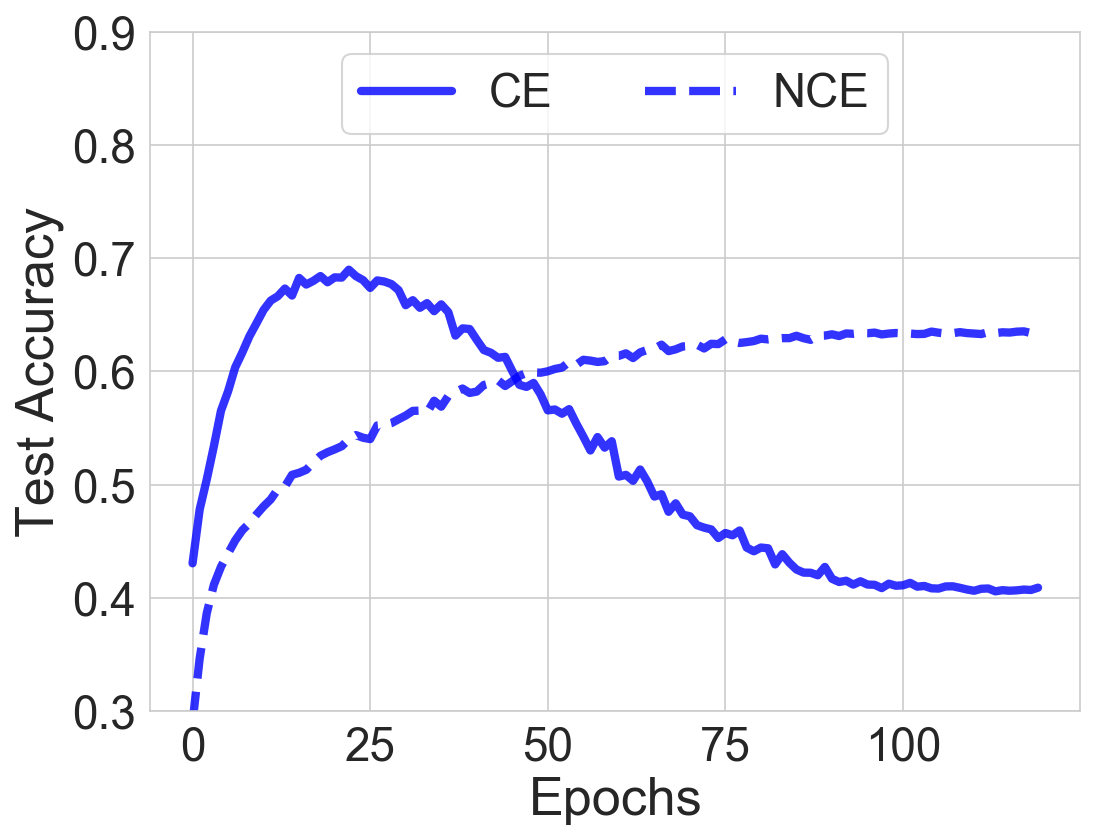

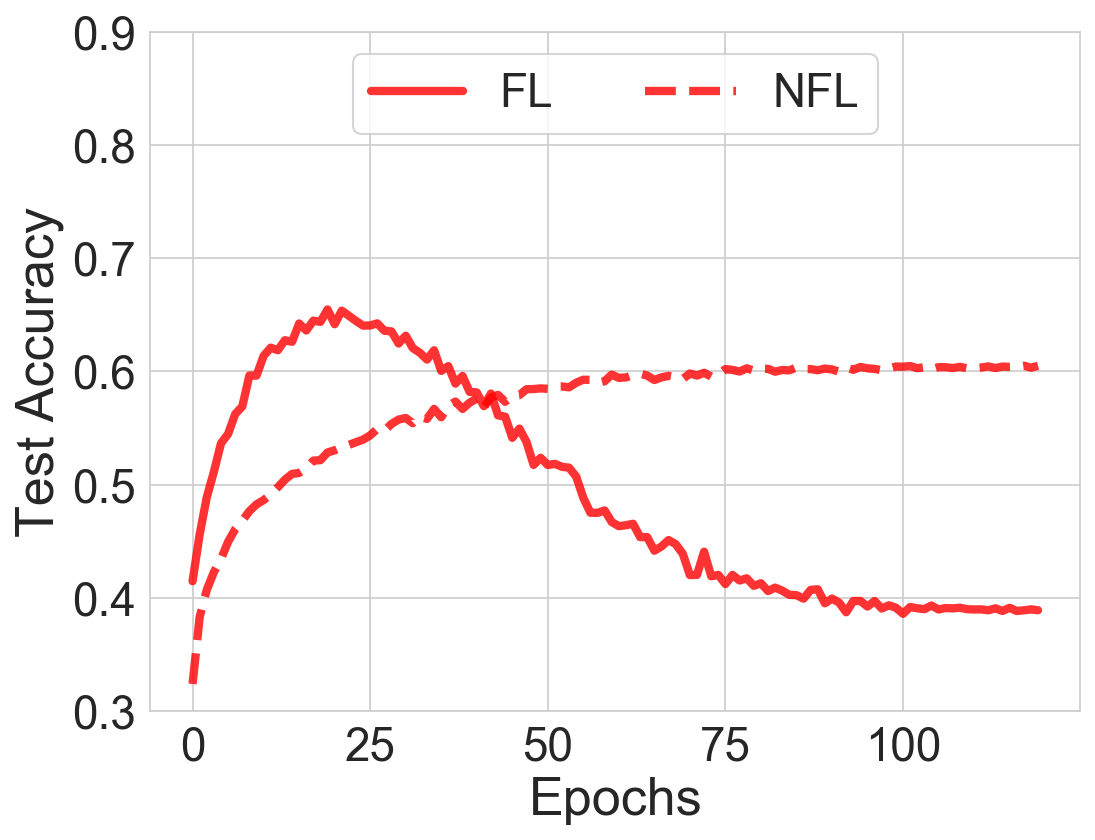

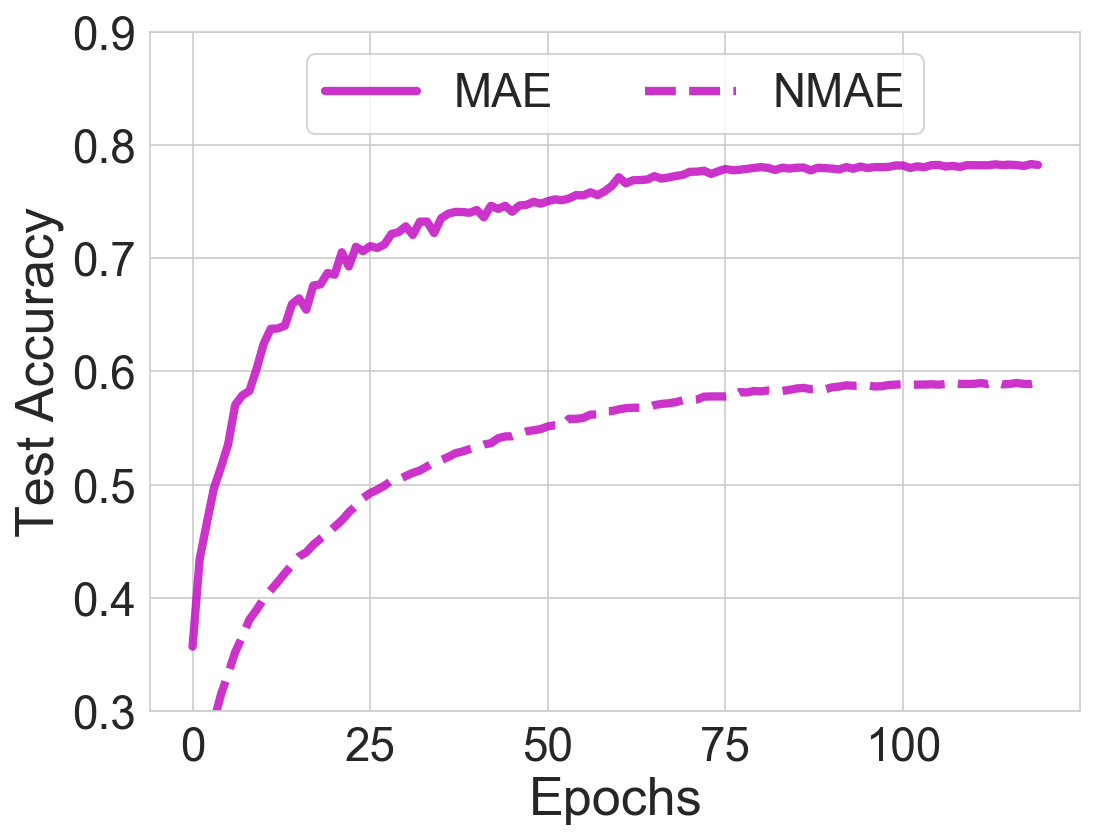

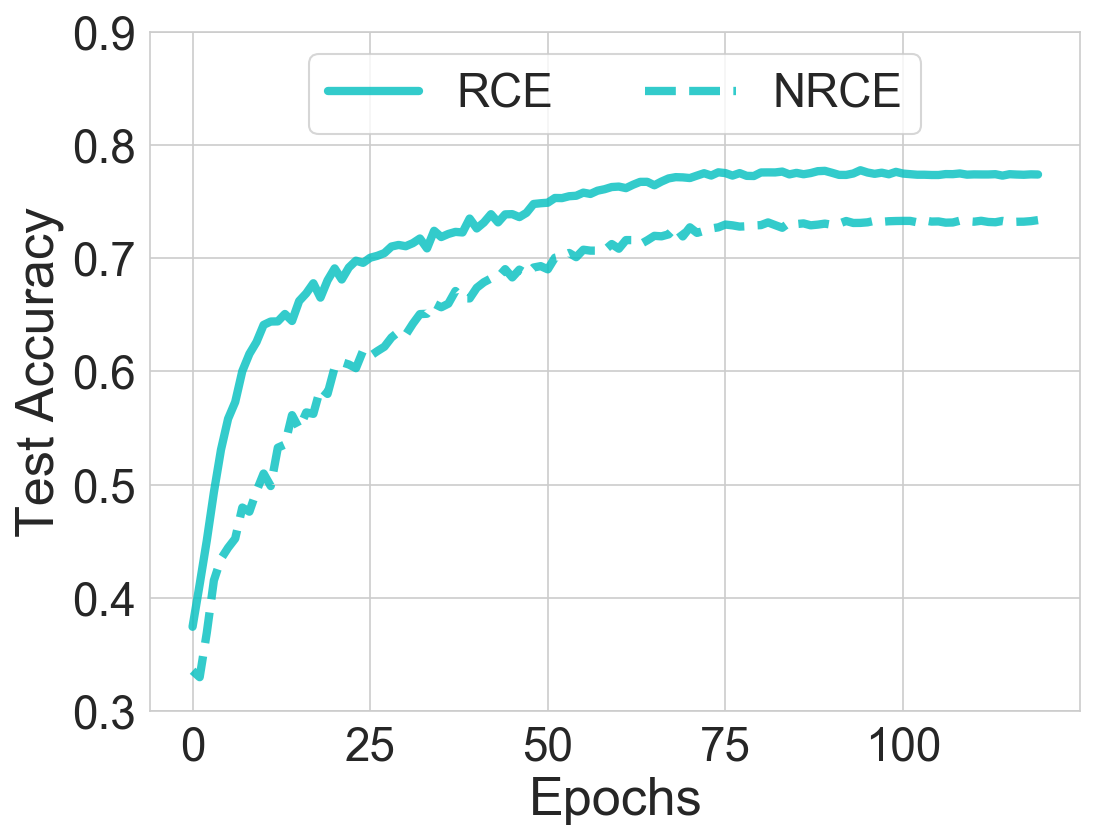

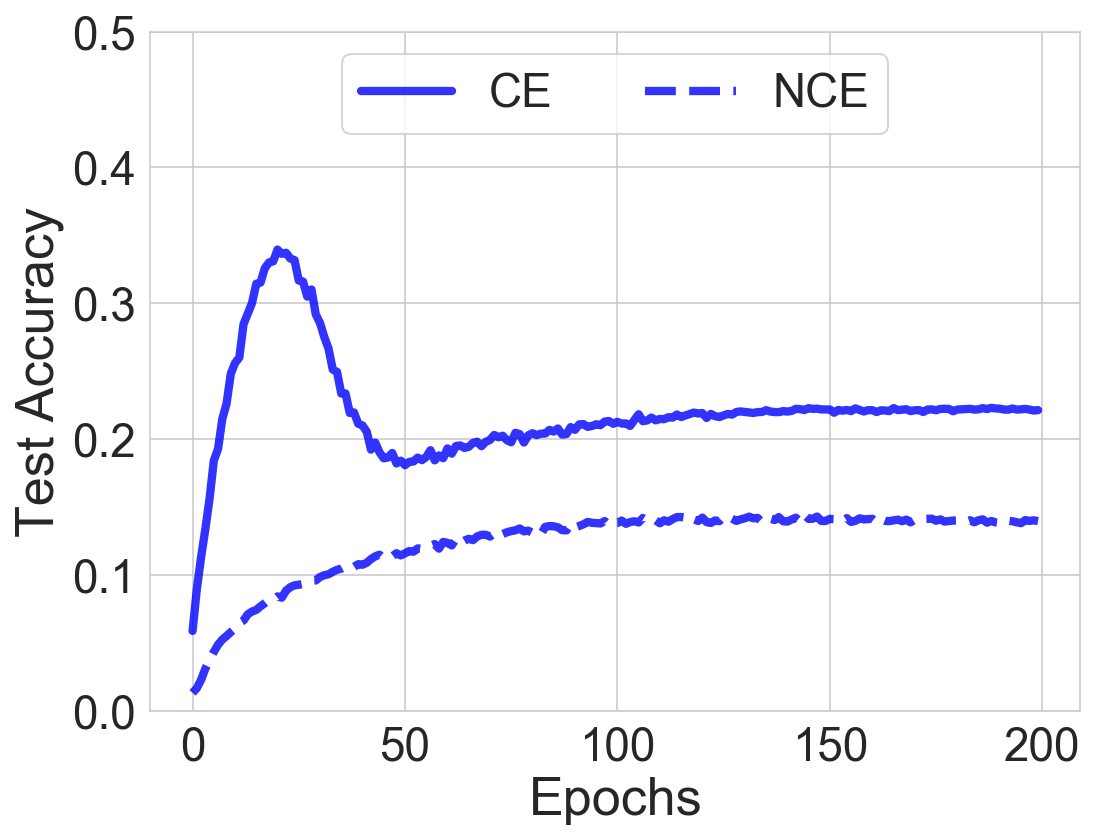

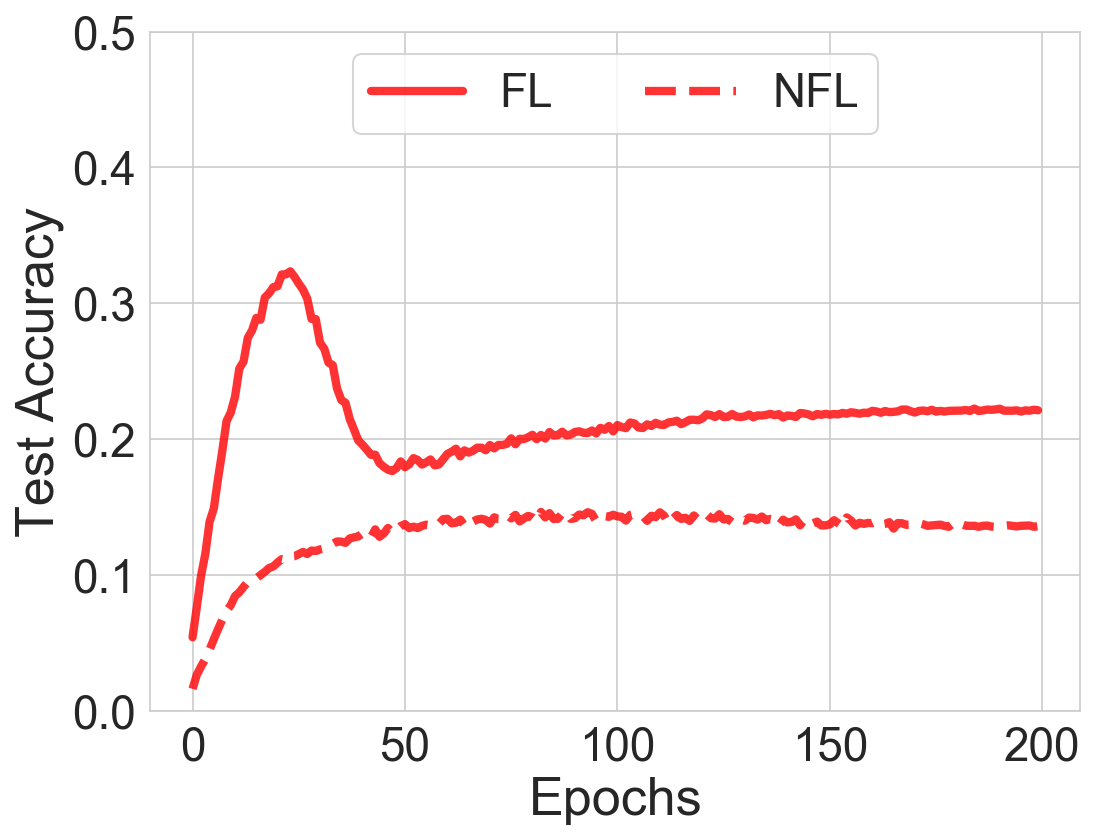

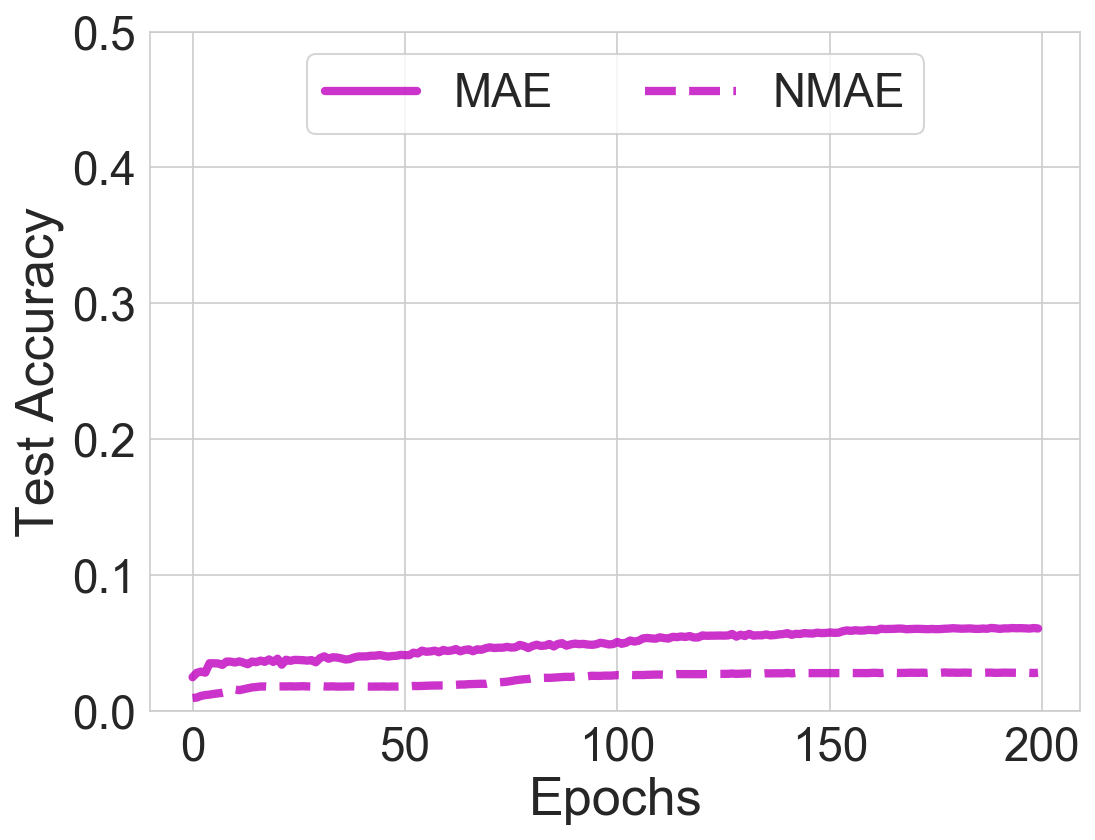

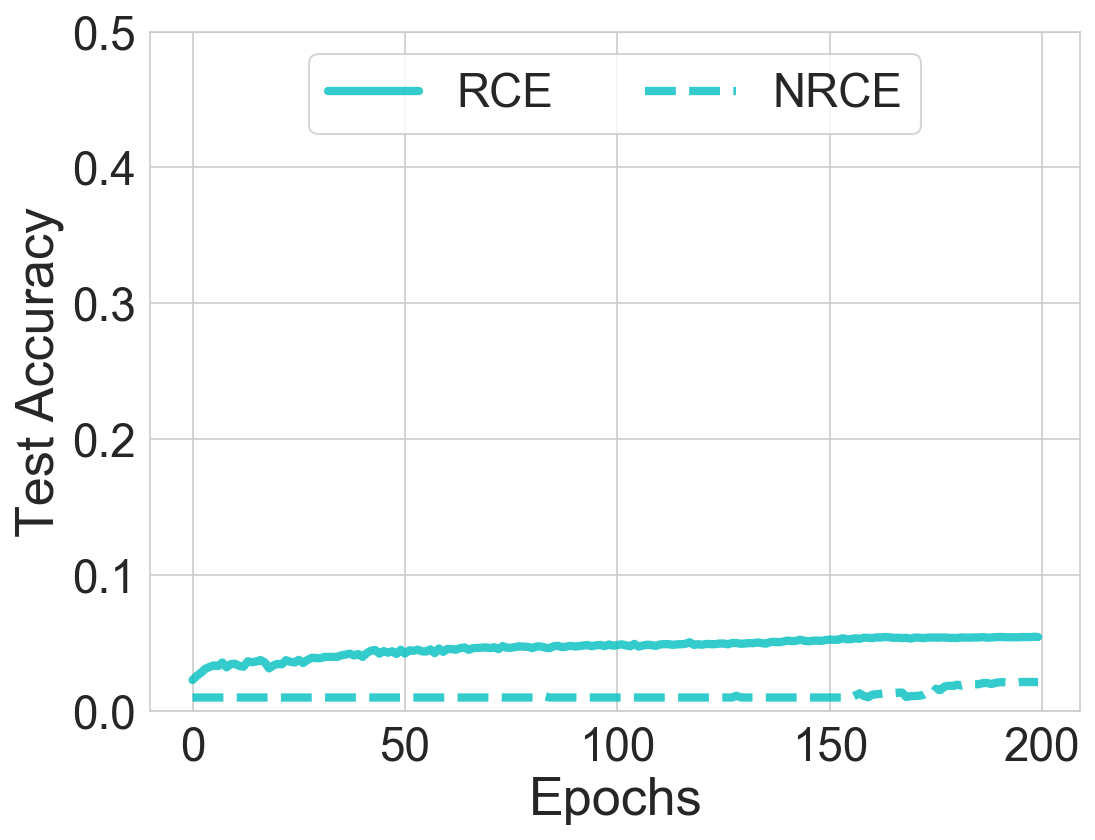

In [10]:

'''
    Plot Graph 1
'''
plot_graph_pair_compare(history=cifar_10_history_sym,
                        nr='0.6',
                        range_min=0.3,
                        range_max=0.9,
                        legend_col=2,
                        legend_loc='upper center',
                        graph_file_name='plot/graph1',
                        targets=[('CE', 'NCE'), ('FL', 'NFL'), ('MAE', 'NMAE'), ('RCE', 'NRCE')])

'''
    Plot Graph 2
'''
plot_graph_pair_compare(history=cifar_100_history_sym,
                        nr='0.6',
                        range_min=0.0,
                        range_max=0.5,
                        legend_col=2,
                        legend_loc='upper center',
                        graph_file_name='plot/graph2',
                        targets=[('CE', 'NCE'), ('FL', 'NFL'), ('MAE', 'NMAE'), ('RCE', 'NRCE')])

<h3>Fig3</h3>

    graph3 scale NCE NGCE RCE MAE Scale by 1 2 4 (5 6 8 10) select 3? split by loss add 'CE as black --' or 'GCE'


In [11]:
def plot_graph_compare(history, nr, targets, graph_file_name, range_min, range_max, lengend_col=1, legend_loc='lower right', labels=None, legend_prop=None):
    fig = plt.figure(figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_xlabel("Epochs", fontsize=25)
    ax.set_ylabel('Test Accuracy', fontsize=25)
    ax.set_ylim(bottom=range_min, top=range_max)
    
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.grid(True, axis='x')
    ax.grid(True, axis='y')
    
    for i, loss_name in enumerate(targets):
        label = loss_name if labels is None else labels[i]
        ax.plot(history[loss_name][nr][0]['test_acc'],
                color=loss_style[loss_name]['color'],
                linestyle=loss_style[loss_name]['linestyle'],
                linewidth=4,
                alpha=0.8,
                label=label)
    if legend_prop is not None:
        ax.legend(ncol=lengend_col, fontsize=22, loc=legend_loc, prop=legend_prop)
    else:
        ax.legend(ncol=lengend_col, fontsize=22, loc=legend_loc)
    plt.savefig(graph_file_name + '.png', bbox_inches='tight')
    plt.show()
    return


In [12]:
# Scale Expriments
target_dir_list = ['checkpoints/cifar100/sym/scale_exp']
cifar_100_history_scale_exp = load_train_history(target_dir_list)
print((plot_table(cifar_100_history_scale_exp, 'test_acc', sym_nr_rates)))


cifar_100_history_scale_exp['CE'] = cifar_100_history_sym['CE']

+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|    Loss    |       0.0       |       0.2       |       0.4       |       0.6       |       0.8       |
+============+=================+=================+=================+=================+=================+
| 1MAE       |    8.98±0.00    |    6.44±0.00    |    6.94±0.00    |    4.09±0.00    |    2.69±0.00    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| 10MAE      |    1.00±0.00    |    1.00±0.00    |    1.00±0.00    |    1.00±0.00    |    1.68±0.00    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| 100MAE     |    1.00±0.00    |    1.00±0.00    |    2.62±0.00    |    1.00±0.00    |    1.48±0.00    |
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| 2MAE       |    3.65±0.00    |    1.00±0.00    |    3

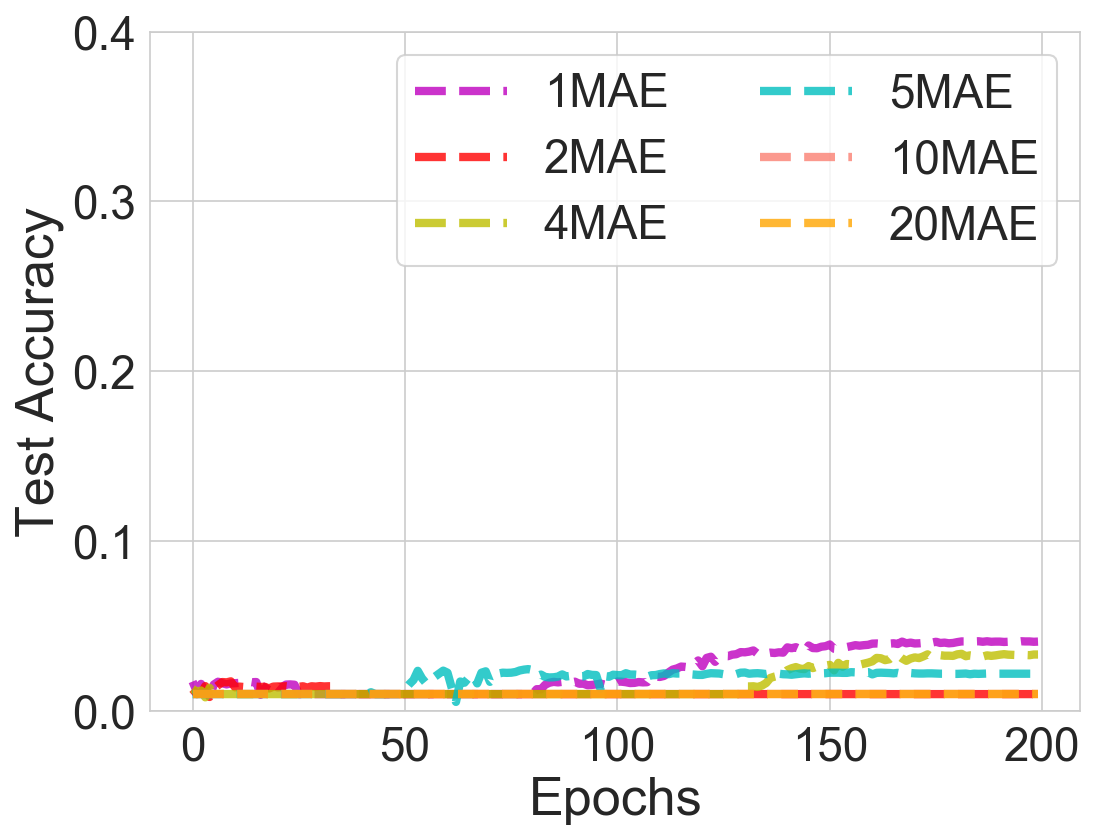

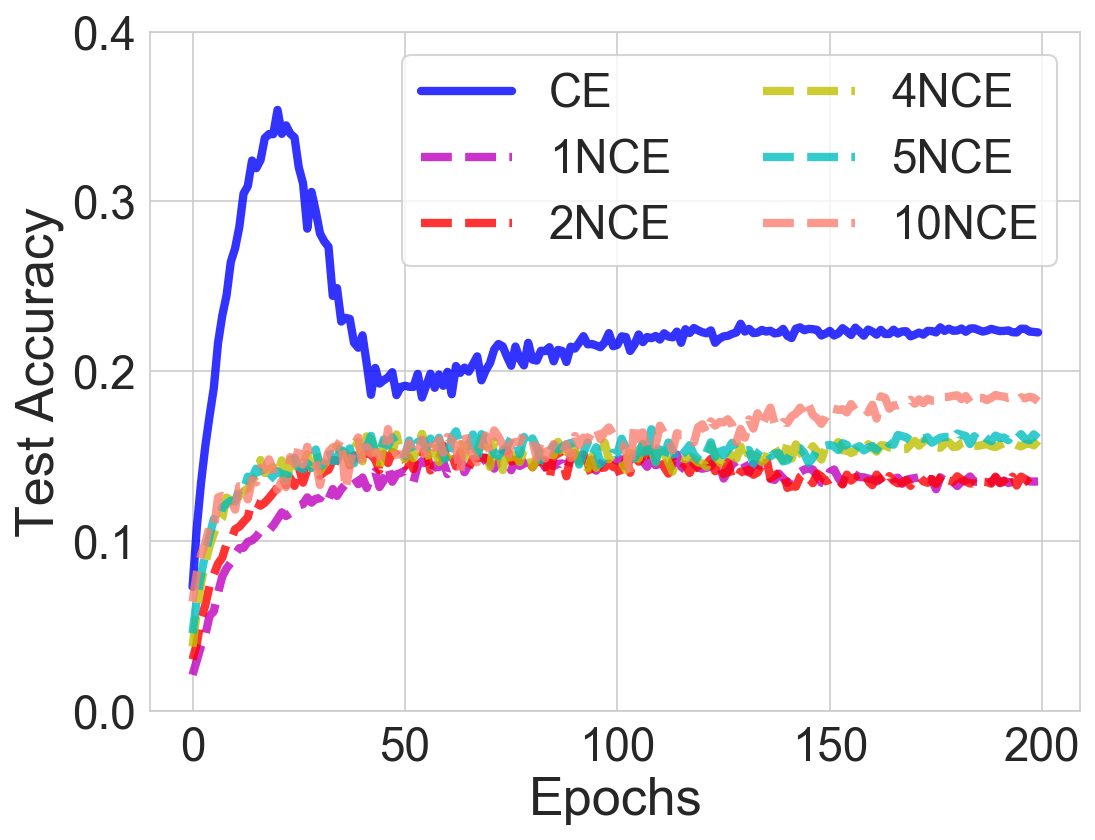

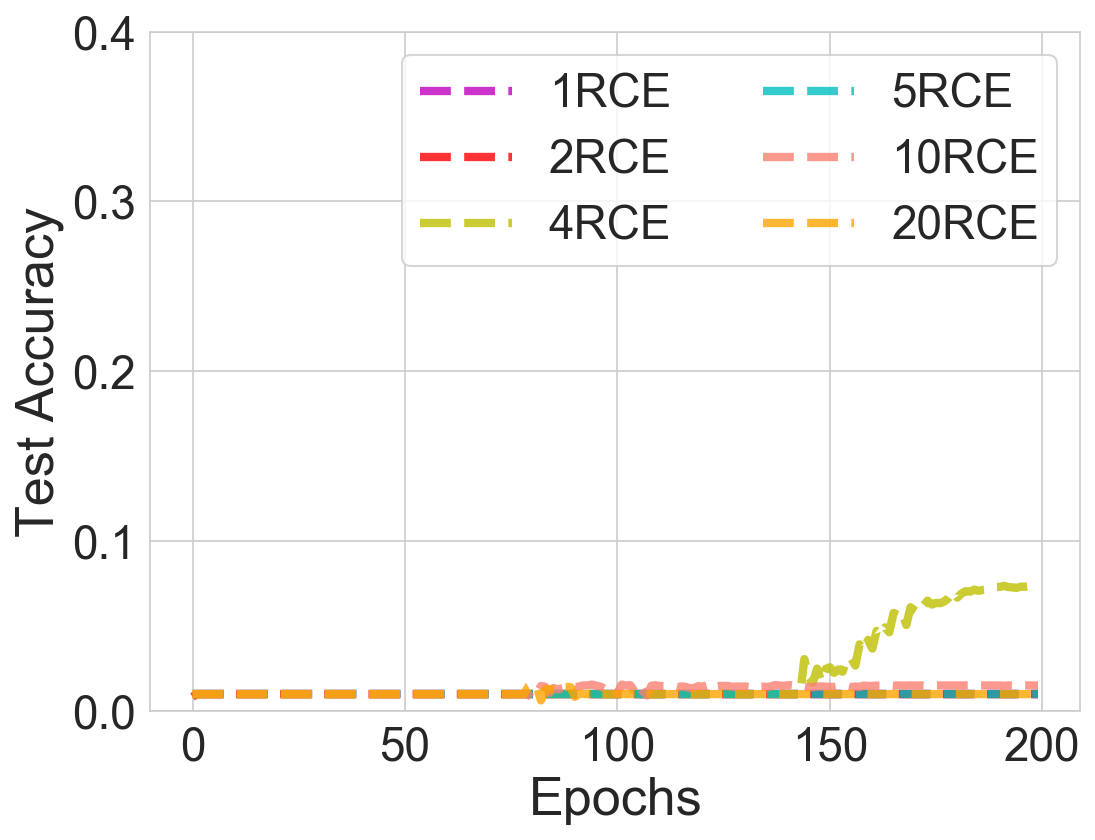

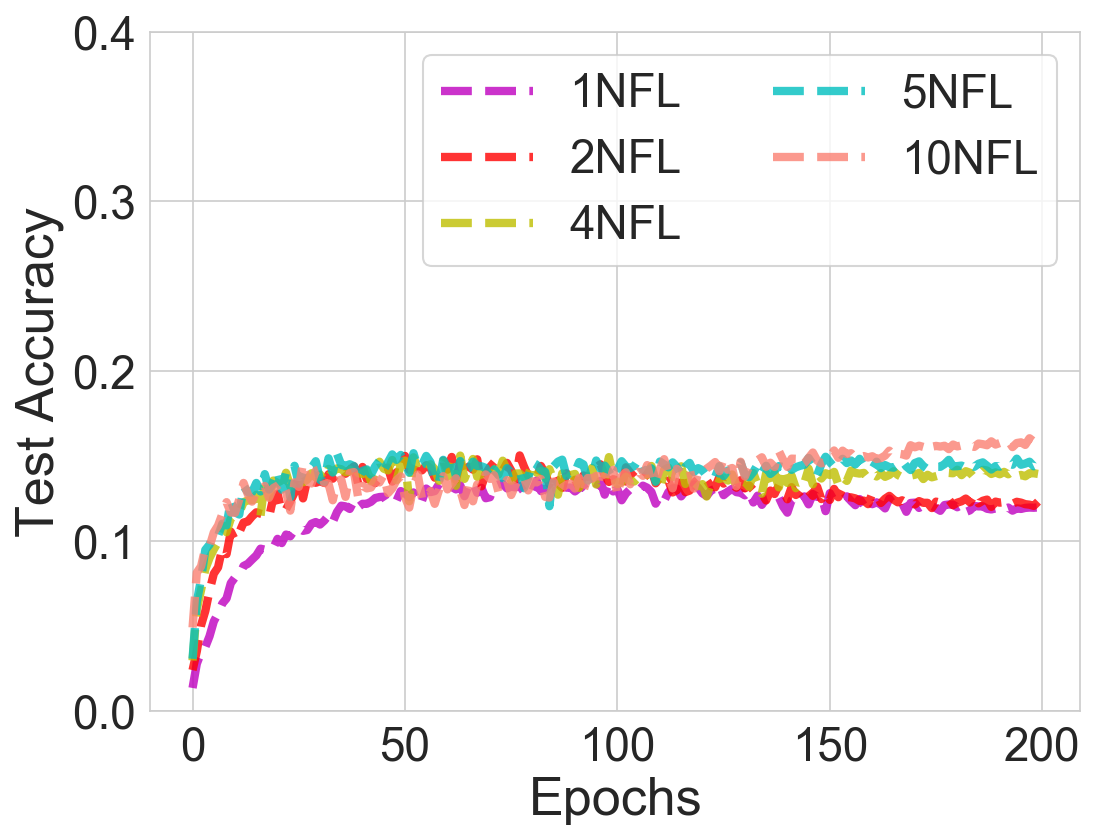

In [13]:
plot_graph_compare(history=cifar_100_history_scale_exp,
                   nr='0.6',
                   lengend_col=2,
                   legend_loc='upper right',
                   range_min=0.0,
                   range_max=0.4,
                   graph_file_name='plot/graph3_scale_MAE',
                   targets=['1MAE', '2MAE', '4MAE', '5MAE', '10MAE', '20MAE'])


plot_graph_compare(history=cifar_100_history_scale_exp,
                   nr='0.6',
                   lengend_col=2,
                   range_min=0.0,
                   range_max=0.4,
                   legend_loc='upper right',
                   graph_file_name='plot/graph3_scale_NCE',
                   targets=['CE', '1NCE', '2NCE', '4NCE', '5NCE', '10NCE'])


plot_graph_compare(history=cifar_100_history_scale_exp,
                   nr='0.6',
                   lengend_col=2,
                   legend_loc='upper right',
                   range_min=0.0,
                   range_max=0.4,
                   graph_file_name='plot/graph3_scale_RCE',
                   targets=['1RCE', '2RCE', '4RCE', '5RCE', '10RCE', '20RCE'])


plot_graph_compare(history=cifar_100_history_scale_exp,
                   nr='0.6',
                   lengend_col=2,
                   range_min=0.0,
                   range_max=0.4,
                   legend_loc='upper right',
                   graph_file_name='plot/graph3_scale_NFL',
                   targets=['1NFL', '2NFL', '4NFL', '5NFL', '10NFL'])








<h3>Fig4</h3>

    +comb cifar-10 0.8 cifar-100 0.6 good(-) not good(--) order legend by good -> not good


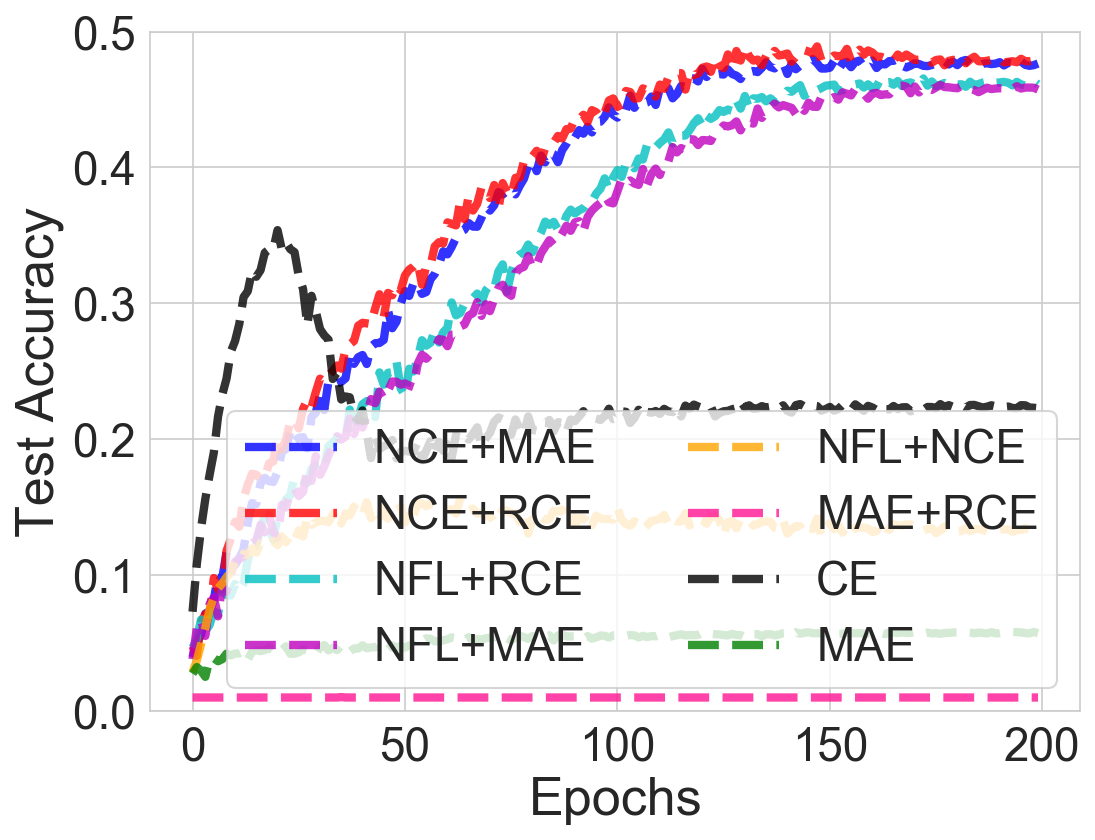

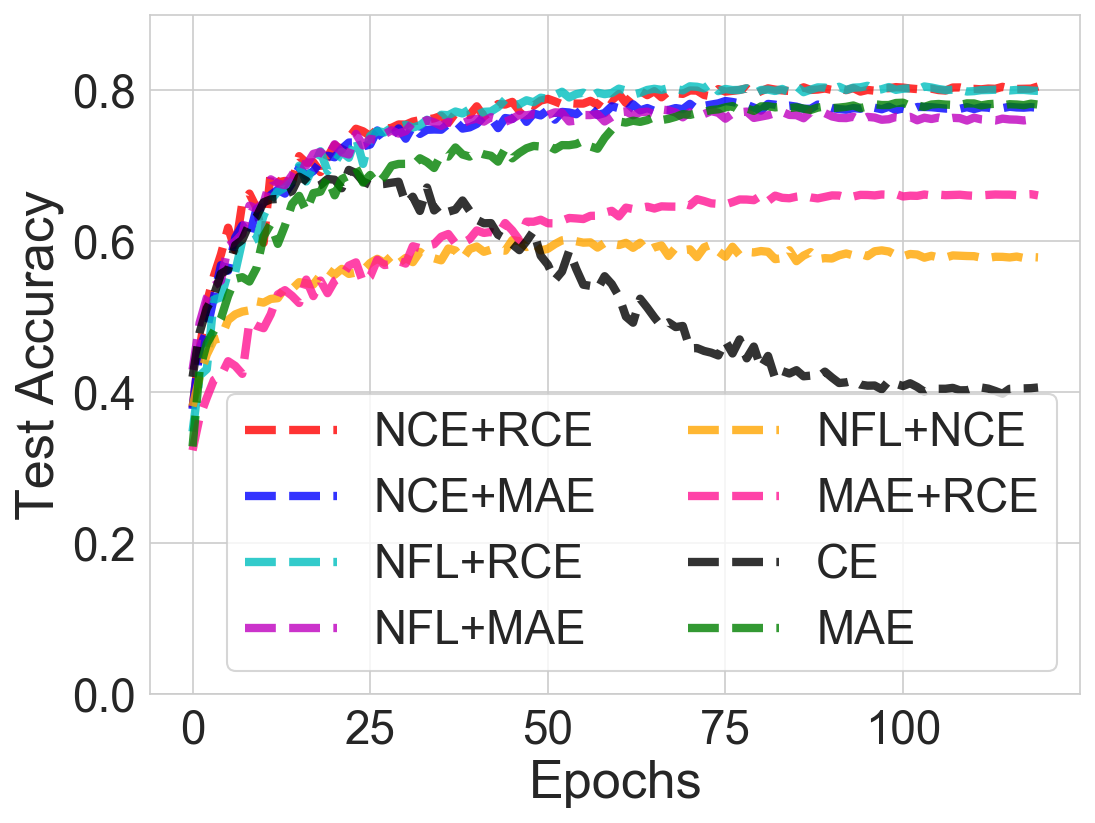

In [14]:
'''
    Plot Graph 4
'''

loss_style['CE'] = {'color': 'black', 'linestyle': '--'}
loss_style['MAE'] = {'color': 'g', 'linestyle': '--'}


plot_graph_compare(history=cifar_100_history_sym,
                   nr='0.6',
                   lengend_col=2,
                   range_min=0.0,
                   range_max=0.5,
                   graph_file_name='plot/graph4_cifar_100_60',
                   targets=['NCE+MAE', 'NCE+RCE', 'NFL+RCE', 'NFL+MAE', 'NFL+NCE', 'MAE+RCE', 'CE', 'MAE'])


plot_graph_compare(history=cifar_10_history_sym,
                   nr='0.6',
                   lengend_col=2,
                   range_min=0.0,
                   range_max=0.9,
                   graph_file_name='plot/graph4_cifar_10_60',
                   targets=['NCE+RCE', 'NCE+MAE', 'NFL+RCE', 'NFL+MAE', 'NFL+NCE', 'MAE+RCE', 'CE', 'MAE'])

<h3>Fig5</h3>

    cifar10/cifar100 test cifar alpha beta scale by lmbda
    
    
    


In [15]:
# Scale Expriments

target_dir_list = ['checkpoints/cifar100/sym/alpha_beta_exp']
cifar_100_history_alpha_beta_exp = load_train_history(target_dir_list)
print((plot_table(cifar_100_history_alpha_beta_exp, 'test_acc', ['0.4'])))




+------------+-----------------+
|    Loss    |       0.4       |
+============+=================+
| NCE+RCE    |    5.32±0.00    |
| alpha=0.1  |                 |
| beta=0.1   |                 |
+------------+-----------------+
| NCE+RCE    |    1.00±0.00    |
| alpha=0.1  |                 |
| beta=1.0   |                 |
+------------+-----------------+
| NCE+RCE    |    1.00±0.00    |
| alpha=0.1  |                 |
| beta=10.0  |                 |
+------------+-----------------+
| NCE+RCE    |    1.00±0.00    |
| alpha=0.1  |                 |
| beta=100.0 |                 |
+------------+-----------------+
| NCE+RCE    |   46.39±0.00    |
| alpha=1.0  |                 |
| beta=0.1   |                 |
+------------+-----------------+
| NCE+RCE    |    1.00±0.00    |
| alpha=1.0  |                 |
| beta=1.0   |                 |
+------------+-----------------+
| NCE+RCE    |    1.78±0.00    |
| alpha=1.0  |                 |
| beta=10.0  |                 |
+---------

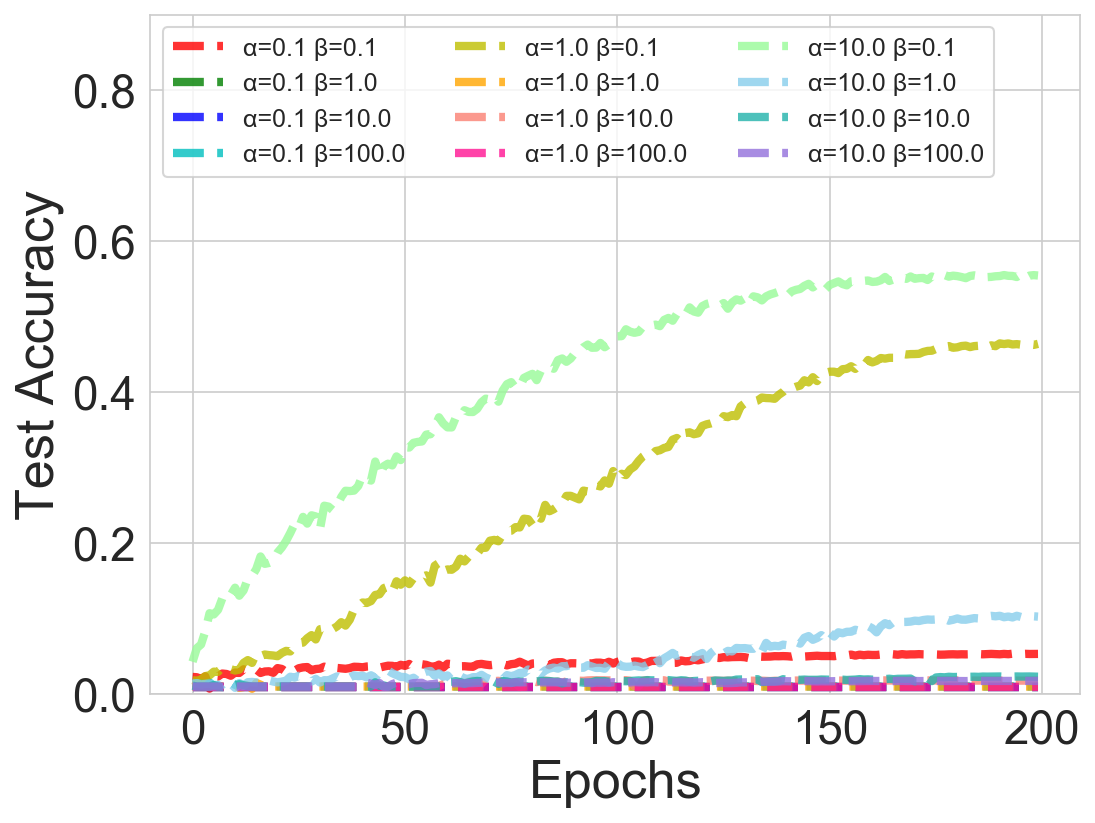

In [16]:
loss_style['NCE+RCE alpha=0.1 beta=0.1'] = {'color': 'r', 'linestyle': '--'}
loss_style['NCE+RCE alpha=0.1 beta=1.0'] = {'color': 'g', 'linestyle': '--'}
loss_style['NCE+RCE alpha=0.1 beta=10.0'] = {'color': 'b', 'linestyle': '--'}
loss_style['NCE+RCE alpha=0.1 beta=100.0'] = {'color': 'c', 'linestyle': '--'}

loss_style['NCE+RCE alpha=1.0 beta=0.1'] = {'color': 'y', 'linestyle': '--'}
loss_style['NCE+RCE alpha=1.0 beta=1.0'] = {'color': 'orange', 'linestyle': '--'}
loss_style['NCE+RCE alpha=1.0 beta=10.0'] = {'color': 'salmon', 'linestyle': '--'}
loss_style['NCE+RCE alpha=1.0 beta=100.0'] = {'color': 'deeppink', 'linestyle': '--'}

loss_style['NCE+RCE alpha=10.0 beta=0.1'] = {'color': 'palegreen', 'linestyle': '--'}
loss_style['NCE+RCE alpha=10.0 beta=1.0'] = {'color': 'skyblue', 'linestyle': '--'}
loss_style['NCE+RCE alpha=10.0 beta=10.0'] = {'color': 'lightseagreen', 'linestyle': '--'}
loss_style['NCE+RCE alpha=10.0 beta=100.0'] = {'color': 'mediumpurple', 'linestyle': '--'}



plot_graph_compare(history=cifar_100_history_alpha_beta_exp,
                   nr='0.4',
                   lengend_col=3,
                   range_min=0.0,
                   range_max=0.9,
                   legend_loc='upper left',
                   legend_prop={'size': 12},
                   graph_file_name='plot/graph5_nce+rce_cifar_100_40',
                   labels=['\u03B1=0.1 \u03B2=0.1',
                           '\u03B1=0.1 \u03B2=1.0',
                           '\u03B1=0.1 \u03B2=10.0',
                           '\u03B1=0.1 \u03B2=100.0',
                           '\u03B1=1.0 \u03B2=0.1',
                           '\u03B1=1.0 \u03B2=1.0',
                           '\u03B1=1.0 \u03B2=10.0',
                           '\u03B1=1.0 \u03B2=100.0',
                           '\u03B1=10.0 \u03B2=0.1',
                           '\u03B1=10.0 \u03B2=1.0',
                           '\u03B1=10.0 \u03B2=10.0',
                           '\u03B1=10.0 \u03B2=100.0',
                          ],
                   targets=['NCE+RCE alpha=0.1 beta=0.1', 
                            'NCE+RCE alpha=0.1 beta=1.0', 
                            'NCE+RCE alpha=0.1 beta=10.0',
                            'NCE+RCE alpha=0.1 beta=100.0',
                            'NCE+RCE alpha=1.0 beta=0.1', 
                            'NCE+RCE alpha=1.0 beta=1.0', 
                            'NCE+RCE alpha=1.0 beta=10.0',
                            'NCE+RCE alpha=1.0 beta=100.0',
                            'NCE+RCE alpha=10.0 beta=0.1', 
                            'NCE+RCE alpha=10.0 beta=1.0', 
                            'NCE+RCE alpha=10.0 beta=10.0',
                            'NCE+RCE alpha=10.0 beta=100.0',
                           ])